# Aprendizaje No Supervisado en Python

Este libro contiene un estudio de **Aprendizaje No Supervisado** utilizando Python. Esto hace parte del curso de Aprendizaje Automático de la Maestría de Ciencia de Datos.

Los integrantes de este trabajo:

* Santiago Echeverri Calderon
* Edgar Leandro Jimenez Jaimes

Realizamos la importación de las librerias a utilizar

In [0]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from  scipy.cluster.hierarchy import linkage, ward, dendrogram

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


Realizamos la carga del data set a utilizar:

Base de datos de reconocimiento de actividad humana construida a partir de las grabaciones de 30 individuos que realizan actividades cotidianas mientras llevan un teléfono inteligente en la cintura con sensores de inercia integrados.
Disponible en: 
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# El dataset original se encuentra dividido en 2 archivos, se consolidarán en un único dataframe

df1 = pd.read_csv('/content/drive/My Drive/CM0891-Aprendizaje-Automatico/Datasets/human-activity-recognition-with-smartphones/train.csv')
df2 = pd.read_csv('/content/drive/My Drive/CM0891-Aprendizaje-Automatico/Datasets/human-activity-recognition-with-smartphones/test.csv')
df_unido = df1.append(df2).reset_index(drop=True)

# Exploracion inicial del conjunto de datos

Realizamos una pequeña revision de los datos que acabamos de importar

In [7]:
df_unido.info()                 # Revisamos el tipo de datos por cada columna    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 44.2+ MB


In [8]:
df_unido.head(5)                # Imprimimos los primeros 5 registros del dataset

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [0]:
# Remoción de las columnas Activity y subject
df_etiquetas = df_unido['Activity'].to_frame(name = 'Activity')
df_atributos = df_unido.drop(['subject', 'Activity'], 1)

In [10]:
# Creación de códigos numéricos para las clases de 'Activity'
lb_activity = LabelEncoder()
df_etiquetas["Activity_code"] = lb_activity.fit_transform(df_etiquetas["Activity"])
codigos = df_etiquetas.groupby(["Activity", "Activity_code"]).size().reset_index(name='count')
codigos

,Activity,Activity_code,count
0,LAYING,0,1944
1,SITTING,1,1777
2,STANDING,2,1906
3,WALKING,3,1722
4,WALKING_DOWNSTAIRS,4,1406
5,WALKING_UPSTAIRS,5,1544


In [11]:
df_atributos.describe()           # Realizamos una estadistica descriptiva rapida del conjunto de datos

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,-0.305180,-0.562230,0.525304,0.389537,0.598022,-0.552087,-0.825460,-0.902704,-0.854662,-0.689162,-0.643512,-0.640686,-0.100332,-0.128765,-0.157863,-0.118954,0.108574,-0.035699,0.122000,-0.029677,0.031724,0.155148,-0.018077,0.006110,0.037729,0.034424,-0.082669,-0.120309,-0.197746,0.102199,...,-0.840996,-0.676629,-0.338469,-0.877800,0.173220,-0.298598,-0.601659,-0.697411,-0.699976,-0.681014,-0.734623,-0.888701,-0.697411,-0.881301,-0.722125,-0.076279,-0.886999,-0.041564,-0.264279,-0.575866,-0.779768,-0.792190,-0.773404,-0.809934,-0.871201,-0.779768,-0.937898,-0.772715,-0.274339,-0.900033,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,0.279920,0.282991,0.356589,0.338844,0.290615,0.461375,0.247052,0.125988,0.205998,0.359209,0.368865,0.372065,

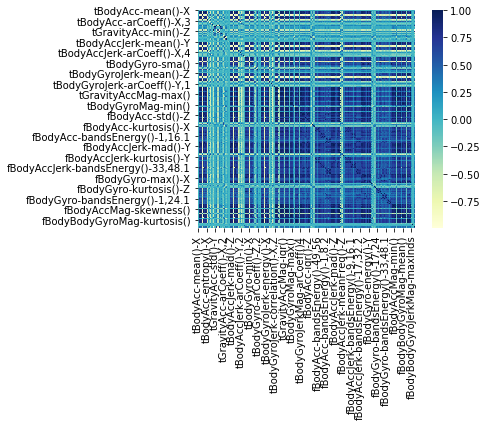

In [12]:
sns.heatmap(df_atributos.corr(), square=True, cmap='YlGnBu')  # Revisamos rapidamente la matriz de correlacion

Revisión de valores nulos

In [13]:
df_atributos.columns[df_atributos.isnull().any()] # Revisamos si hay atributos con valores nulos

Index([], dtype='object')

Selección de atributos mediante PCA

In [14]:
pca = PCA(.949)
pca.fit(df_atributos.values)
atributos_pca = pca.transform(df_atributos.values)
print(pca.n_components_)

68


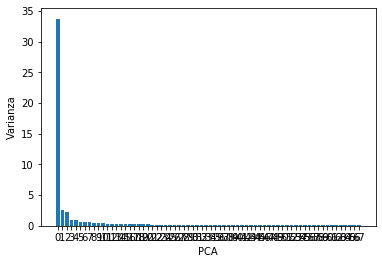

In [15]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA')
plt.ylabel('Varianza')
plt.xticks(features)
plt.show()

## Algoritmos de Clustering

### k-means


In [0]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(atributos_pca)

In [17]:
# Obtener label de cluster para cada observación
df_km_clusters = pd.DataFrame(kmeans.labels_, columns=["cluster"])

# Unir label original y label de cluster
result_km = pd.concat([df_etiquetas, df_km_clusters], axis=1, sort=False)

# Obtener resultado agrupado, cantidad de observaciones por clase en cada cluster
agrupado = result_km.groupby(['cluster', 'Activity', 'Activity_code']).size().to_frame(name = 'count').reset_index()
agrupado

,cluster,Activity,Activity_code,count
0,0,LAYING,0,12
1,0,SITTING,1,3
2,0,WALKING,3,700
3,0,WALKING_DOWNSTAIRS,4,187
4,0,WALKING_UPSTAIRS,5,1166
5,1,SITTING,1,1257
6,1,STANDING,2,1240
7,2,WALKING,3,153
8,2,WALKING_DOWNSTAIRS,4,456
9,2,WALKING_UPSTAIRS,5,82


In [18]:
# Calcular categoría de mayor frecuencia en el cluster
idx = agrupado.groupby(['cluster'])['count'].transform(max) == agrupado['count']
equivalencia_clusters = agrupado[idx]
equivalencia_clusters

,cluster,Activity,Activity_code,count
4,0,WALKING_UPSTAIRS,5,1166
5,1,SITTING,1,1257
8,2,WALKING_DOWNSTAIRS,4,456
12,3,STANDING,2,666
13,4,LAYING,0,1760
15,5,WALKING,3,869


In [19]:
# Evaluar la pureza de la agrupación
pureza = agrupado[idx]['count'].sum()/result_km.shape[0]
print('Pureza ', pureza)

Pureza  0.5994756772502184


$\displaystyle Pureza\ =\dfrac{1}{N} \ \sum ^{k}_{i=1} max_{j} |c_{i} \cap t_{j} |$

$\displaystyle N:$observaciones

$\displaystyle k:$número de clusters

$\displaystyle c_{i} :$cluster i

$\displaystyle t_{j} :$categoria j

https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html#fig:clustfg3

In [20]:
# Evaluar el coeficiente de silueta
preds = kmeans.fit_predict(atributos_pca)
ss = silhouette_score(atributos_pca, preds)
ss

0.15057197049599833

### DBSCAN


In [48]:
dbscan = DBSCAN(eps=5, min_samples=90).fit(atributos_pca)
df_db_clusters = pd.DataFrame(dbscan.labels_, columns=["cluster"])
result_db = pd.concat([df_etiquetas, df_db_clusters], axis=1, sort=False)
result_db.groupby(['cluster']).count()

,Activity,Activity_code
cluster,,
-1,369,369
0,9930,9930


### Jerarquico Aglomerativo

In [22]:
jerarquico = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(atributos_pca)

# Obtener label de cluster para cada observación
df_jq_clusters = pd.DataFrame(jerarquico, columns=["cluster"])

# Unir label original y label de cluster
result_jq = pd.concat([df_etiquetas, df_jq_clusters], axis=1, sort=False)

# Obtener resultado agrupado, cantidad de observaciones por clase en cada cluster
agrupado = result_jq.groupby(['cluster', 'Activity', 'Activity_code']).size().to_frame(name = 'count').reset_index()
agrupado

,cluster,Activity,Activity_code,count
0,0,LAYING,0,1944
1,0,SITTING,1,65
2,0,STANDING,2,2
3,1,WALKING,3,1421
4,1,WALKING_DOWNSTAIRS,4,1021
5,1,WALKING_UPSTAIRS,5,497
6,2,SITTING,1,1021
7,2,STANDING,2,923
8,3,WALKING,3,250
9,3,WALKING_DOWNSTAIRS,4,138


In [23]:
# Calcular categoría de mayor frecuencia en el cluster
idx = agrupado.groupby(['cluster'])['count'].transform(max) == agrupado['count']
equivalencia_clusters = agrupado[idx]
equivalencia_clusters

,cluster,Activity,Activity_code,count
0,0,LAYING,0,1944
3,1,WALKING,3,1421
6,2,SITTING,1,1021
10,3,WALKING_UPSTAIRS,5,1032
12,4,WALKING_DOWNSTAIRS,4,247
15,5,STANDING,2,981


In [24]:
# Evaluar la pureza de la agrupación
pureza = agrupado[idx]['count'].sum()/result_jq.shape[0]
print('Pureza ', pureza)

Pureza  0.6453053694533449


In [25]:
# Evaluar el coeficiente de silueta
ss = silhouette_score(atributos_pca, df_jq_clusters.values)
ss

0.09940657109089857

### Visualización

In [0]:
# Relacionar cluster con clase principal
df_result_labeled = result_jq.merge(equivalencia_clusters, left_on='cluster', right_on='cluster')
df_result_labeled = df_result_labeled.rename(columns={'Activity_code_x': 'Actividad_real', 'Activity_code_y': 'Actividad_cluster'})

Visualización de los clusters obtenidos mediante algoritmo jerarquico algomerativo en las 2 componentes más importantes

In [27]:
pca2 = PCA(n_components=2)
principalComponents = pca2.fit_transform(atributos_pca)
print('varianza explicada 2CP: ',sum(pca2.explained_variance_))

varianza explicada 2CP:  36.33463881267728


In [0]:
principalComponents = pca2.fit_transform(atributos_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['CP1', 'CP2'])
finalDf = pd.concat([principalDf, df_result_labeled[['Actividad_real', 'Actividad_cluster']]], axis = 1)

No handles with labels found to put in legend.


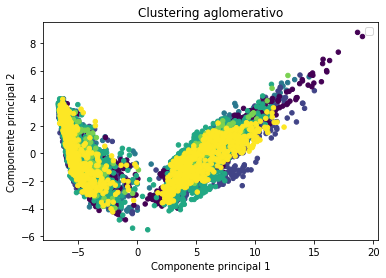

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(finalDf['CP1'],finalDf['CP2'],
                     c=finalDf['Actividad_cluster'],s=20)

ax.set_title('Clustering aglomerativo')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')

ax.legend()
plt.show()

Visualización de los clusters obtenidos mediante algoritmo jerarquico algomerativo en las 3 componentes más importantes

In [30]:
pca3 = PCA(n_components=3)
principalComponents = pca3.fit_transform(df_atributos.values)
print('varianza explicada 3 CP: ',sum(pca3.explained_variance_))

varianza explicada 3 CP:  38.513747273642196


In [0]:
principalComponents = pca3.fit_transform(atributos_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['CP1', 'CP2', 'CP3'])
finalDf = pd.concat([principalDf, df_result_labeled[['Actividad_real', 'Actividad_cluster']]], axis = 1)


No handles with labels found to put in legend.


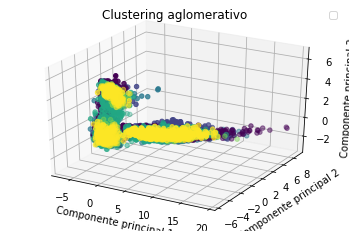

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(finalDf['CP1'],finalDf['CP2'],finalDf['CP3'],
                     c=finalDf['Actividad_cluster'],s=20)


ax.set_title('Clustering aglomerativo')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')

ax.legend()
plt.show()

Validación del número de clusters (k) para el algoritmo k-means mediante el método 'elbow'

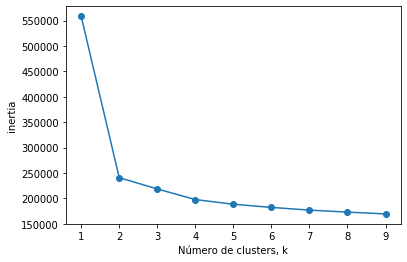

In [33]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters= k)
    model.fit(df_atributos.values)
    inertias.append(model.inertia_) 

plt.plot(ks, inertias, '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Validación del número de clusters (k) para el algoritmo jerarquico aglomerativo mediante el uso de dendogramas

In [0]:
model = linkage(atributos_pca, method='complete')  # metodo complete
model2 = ward(atributos_pca)

Dendograma clustering aglomerativo enlace completo

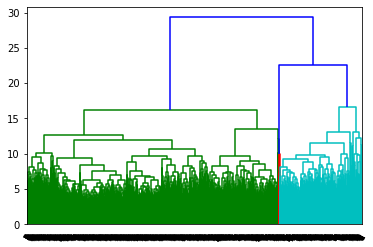

In [35]:
dendrogram(model,
           labels=None,
           leaf_rotation=150,
           leaf_font_size=3,
)
plt.show()

Dendograma clustering aglomerativo enlace ward

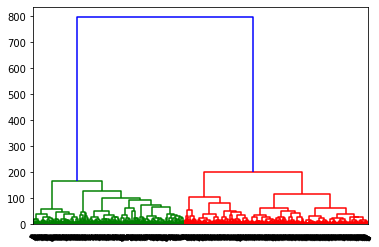

In [36]:
dendrogram(model2,
           labels=None,
           leaf_rotation=150,
           leaf_font_size=3,
)
plt.show()

## Etapa 2: clustering de las actividades estáticas

Filtrado del dataset para escoger las observaciones de actividades estáticas (sentado, acostado, de pie)

In [37]:
# Seleccion de las actividades estaticas
df_estaticas = df_unido.loc[df_unido['Activity'].isin(['STANDING','SITTING','LAYING'])]

# Remoción de las columnas Activity y subject
df_etiquetas_est = df_estaticas['Activity'].to_frame(name = 'Activity')
df_atributos_est = df_estaticas.drop(['subject', 'Activity'], 1)

# Creación de códigos numéricos para las clases de 'Activity'
lb_activity = LabelEncoder()
df_etiquetas_est["Activity_code"] = lb_activity.fit_transform(df_etiquetas_est["Activity"])
codigos_est = df_etiquetas_est.groupby(["Activity", "Activity_code"]).size().reset_index(name='count')
codigos_est

,Activity,Activity_code,count
0,LAYING,0,1944
1,SITTING,1,1777
2,STANDING,2,1906


Reducción de dimensionalidad mediante PCA

In [38]:
pca = PCA(.95)
pca.fit(df_atributos_est.values)
atributos_pca_est = pca.transform(df_atributos_est.values)
print(pca.n_components_)

77


Agrupamiento mediante clustering jerarquico aglomerativo con el enlace tipo ward

In [39]:
jerarquico2 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(atributos_pca_est)

# Obtener label de cluster para cada observación
df_jq_clusters = pd.DataFrame(jerarquico2, columns=["cluster"])

# Unir label original y label de cluster
result_jq = pd.concat([df_etiquetas_est, df_jq_clusters], axis=1, sort=False)

# Obtener resultado agrupado, cantidad de observaciones por clase en cada cluster
agrupado = result_jq.groupby(['cluster', 'Activity', 'Activity_code']).size().to_frame(name = 'count').reset_index()
agrupado

,cluster,Activity,Activity_code,count
0,0.0,LAYING,0.0,798
1,0.0,SITTING,1.0,556
2,0.0,STANDING,2.0,655
3,1.0,LAYING,0.0,187
4,1.0,SITTING,1.0,376
5,1.0,STANDING,2.0,306
6,2.0,LAYING,0.0,87
7,2.0,SITTING,1.0,56
8,2.0,STANDING,2.0,94


In [40]:
# Calcular categoría de mayor frecuencia en el cluster
idx = agrupado.groupby(['cluster'])['count'].transform(max) == agrupado['count']
equivalencia_clusters = agrupado[idx]
equivalencia_clusters

,cluster,Activity,Activity_code,count
0,0.0,LAYING,0.0,798
4,1.0,SITTING,1.0,376
8,2.0,STANDING,2.0,94


In [41]:
# Evaluar la pureza de la agrupación
pureza = agrupado[idx]['count'].sum()/result_jq.shape[0]
print('Pureza ', pureza)

Pureza  0.15579309497481264
